<a href="https://colab.research.google.com/github/krishnarevi/Attention_model_from_scratch/blob/main/Prediction_of_bad_deliveries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from math import sqrt

from sklearn.model_selection  import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn import tree
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, r2_score,mean_squared_error
#import graphviz

%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
 
import scipy.stats as scs
import scipy.stats as stats

import statsmodels.api as sm
from datetime import date, datetime, time
import os
import json
import seaborn as sns

import catboost as cat
from sklearn.linear_model import LassoLars
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
sns.set(style='whitegrid')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# mount g-drive to access datafiles
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# setting path
path= '/content/drive/MyDrive/data/location_task'
os.chdir(path)
print("current dir is: %s" % (path))

current dir is: /content/drive/MyDrive/data/location_task


In [ ]:

# reading data files
with open("location_task_no_nulls.json", "r") as read_file:
    data = json.load(read_file)

In [ ]:
df = pd.DataFrame(data)
df.head()

,order_id,order_value,order_items_count,customer_id,created_timestamp_local,has_instruction,logistics_dropoff_distance,delivery_postal_code,delivery_geohash_precision8,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction
618,b8ds-tqhf,40.440,10,h6huq0td,2021-03-11T20:19:50,True,58.656,828868,w23bh248,False,False,False,False,False,False,False,False
619,x5xx-j2d2,35.600,10,t2nod4rq,2021-03-12T18:42:48,True,39.025,530548,w21zu55k,False,False,False,False,False,False,False,False
620,x6qu-14kt,42.490,12,m4ycd3tm,2021-03-27T11:29:17,True,40.068,650248,w21z9jc4,False,False,True,False,False,False,False,False
621,x3yw-rhc5,14.400,11,sgmnf9sb,2021-03-02T22:08:52,True,44.987,550105,w21zg97y,False,False,False,False,False,False,False,False
622,y9zp-58q7,38.150,10,x4rvv3iy,2021-03-23T20:35:26,True,71.521,102112,w21z61q6,False,False,False,False,False,False,False,False


## Exploratory Data Analysis (EDA) & Feature Engineering

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2593799 entries, 618 to 2964438
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   order_id                     object 
 1   order_value                  float64
 2   order_items_count            int64  
 3   customer_id                  object 
 4   created_timestamp_local      object 
 5   has_instruction              bool   
 6   logistics_dropoff_distance   float64
 7   delivery_postal_code         object 
 8   delivery_geohash_precision8  object 
 9   has_phone_number             bool   
 10  has_call_instruction         bool   
 11  has_leave_instruction        bool   
 12  has_lift_instruction         bool   
 13  has_lobby_instruction        bool   
 14  has_gate_instruction         bool   
 15  has_knock_instruction        bool   
 16  has_bell_instruction         bool   
dtypes: bool(9), float64(2), int64(1), object(5)
memory usage: 200.4+ MB


In [ ]:
print("shape of df is {} ".format(df.shape))

shape of df is (2593799, 17) 


In [ ]:
#convert two float columns(order_value and logistics_dropoff_distance ) into int ,this will save space , also doesn't affect model performance much
df['logistics_dropoff_distance'] = np.floor(pd.to_numeric(df['logistics_dropoff_distance'], errors='coerce')).astype('Int64')
df['order_value'] = np.floor(pd.to_numeric(df['order_value'], errors='coerce')).astype('Int64')

In [ ]:
#Checking for null values 
print(df.isna().sum())

order_id                       0
order_value                    0
order_items_count              0
customer_id                    0
created_timestamp_local        0
has_instruction                0
logistics_dropoff_distance     0
delivery_postal_code           0
delivery_geohash_precision8    0
has_phone_number               0
has_call_instruction           0
has_leave_instruction          0
has_lift_instruction           0
has_lobby_instruction          0
has_gate_instruction           0
has_knock_instruction          0
has_bell_instruction           0
dtype: int64


In [ ]:
df.describe()

,order_value,order_items_count,logistics_dropoff_distance
count,2593799.000,2593799.000,2593799.000
mean,20.631,2.607,93.040
std,16.008,1.975,16524.893
min,0.000,1.000,0.000
25%,11.000,1.000,21.000
50%,16.000,2.000,37.000
75%,25.000,3.000,63.000
max,872.000,61.000,15328253.000


In [ ]:
df.nunique()

order_id                       2593799
order_value                        413
order_items_count                   53
customer_id                     565549
created_timestamp_local        1376285
has_instruction                      2
logistics_dropoff_distance        5854
delivery_postal_code             47891
delivery_geohash_precision8     119673
has_phone_number                     2
has_call_instruction                 2
has_leave_instruction                2
has_lift_instruction                 2
has_lobby_instruction                2
has_gate_instruction                 2
has_knock_instruction                2
has_bell_instruction                 2
dtype: int64

###EDA on logistics_dropoff_distance

In [ ]:
#dividing relevance scores into two categories for easier analysis if logistics_dropoff_distance > 10km(10000 mtrs) we say distance is "huge", between 1000 and 10000 "large" otherwise "small"
df['class'] = df['logistics_dropoff_distance'].apply(lambda x: 'small' if x<1000.0 else ('large' if x<10000 else "huge"))
# lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)

In [ ]:
df['class'].value_counts()

small    2576369
large      16489
huge         941
Name: class, dtype: int64

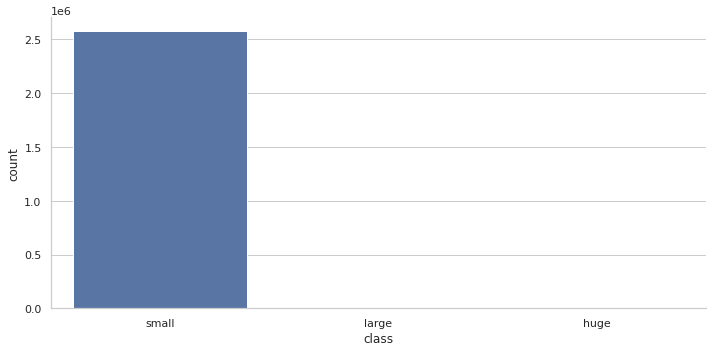

In [ ]:
sns.catplot(x='class', kind='count', data=df, height=5, aspect=2)
plt.show()



*   There is a significant class imbalance here
*   Orders where logistics_dropoff_distance is greater than 10 km is just 0.03% of total orders
*   Orders where logistics_dropoff_distance is greater than 1 km but less than 10 km is around 0.6% of total orders






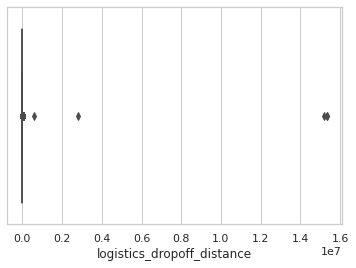

In [ ]:
sns.boxplot(df['logistics_dropoff_distance'])

There are some outliers present in data , having a logistics dropoff distance greater than 10km is unusual 

In [ ]:
# # remove outliers from data based on target column 
# def remove_outlier(df_in, col_name):
#     q1 = df_in[col_name].quantile(0.25)
#     q3 = df_in[col_name].quantile(0.75)
#     iqr = q3-q1 #Interquartile range
#     fence_low  = q1-1.5*iqr
#     fence_high = q3+1.5*iqr
#     df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
#     return df_out

###Removing outliers

In [ ]:
#remove outliers with quantile filter

q_hi  = df["logistics_dropoff_distance"].quantile(0.997) # remove top .005 quantile

cleaned_df = df[df["logistics_dropoff_distance"] < q_hi]

In [ ]:
cleaned_df.describe()

,order_value,order_items_count,logistics_dropoff_distance
count,2586017.000,2586017.000,2586017.000
mean,20.623,2.607,59.894
std,15.989,1.974,110.438
min,0.000,1.000,0.000
25%,11.000,1.000,21.000
50%,16.000,2.000,37.000
75%,25.000,3.000,63.000
max,872.000,61.000,1832.000




*   Now the maximum value in logistics_dropoff_distance is 1832m (~ 2km) which does not seem unusual for dropoff distance




In [ ]:
cleaned_df.columns

Index(['order_id', 'order_value', 'order_items_count', 'customer_id',
       'created_timestamp_local', 'has_instruction',
       'logistics_dropoff_distance', 'delivery_postal_code',
       'delivery_geohash_precision8', 'has_phone_number',
       'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction', 'class'],
      dtype='object')

###Removing redundant columns

In [ ]:
# The attributes "delivery_postal_code","customer_id"  and "delivery_geohash_precision8"  can be removed
# Since they are not important factor affecting the logistics_dropoff_distance
cleaned_df = cleaned_df[['order_id', 'order_value', 'order_items_count', 'created_timestamp_local', 'has_instruction',
       'logistics_dropoff_distance', 'has_phone_number',
       'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction', 'class']]



###EDA on  numerical features 

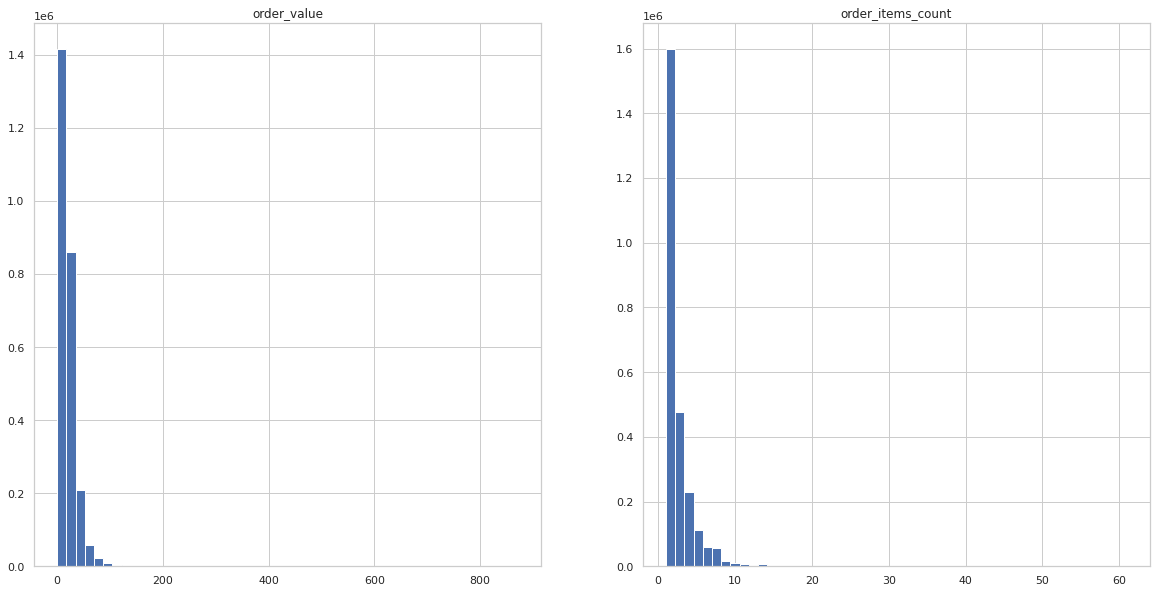

In [ ]:
#check Numerical variables distribution
Numerical_column = ['order_value',  'order_items_count']
fig, axes = plt.subplots(1,2, figsize=(20,10))
for i,n in enumerate(Numerical_column):
    axes[i].hist(cleaned_df[n],bins=50)
    axes[i].set_title(n)



*   Most of the times order value is less than 100

*   Most of the times order count is less than 15



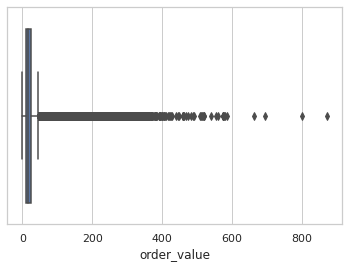

In [ ]:
sns.boxplot(cleaned_df['order_value'])

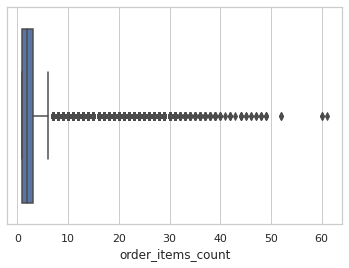

In [ ]:
sns.boxplot(cleaned_df['order_items_count'])

###EDA on boolean features

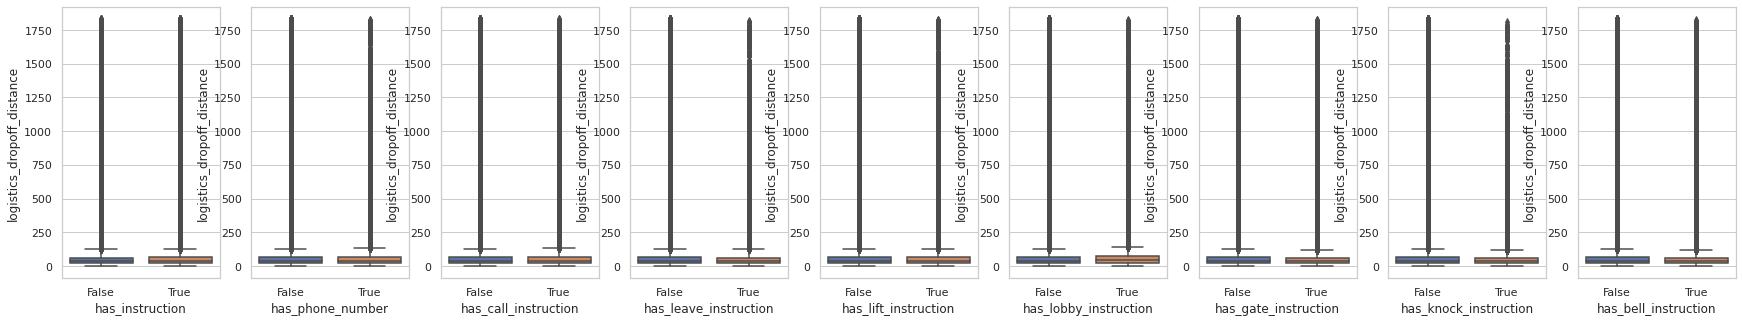

In [ ]:
# Proceed to perform EDA on the remaining binary attributes

columns_binary = ['has_instruction','has_phone_number',
       'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction']

fig, ax = plt.subplots(1, 9, figsize=(30, 5))
for i, column in enumerate(columns_binary):
    sns.boxplot(x=column, y='logistics_dropoff_distance', data=cleaned_df, ax=ax[i])
plt.show()

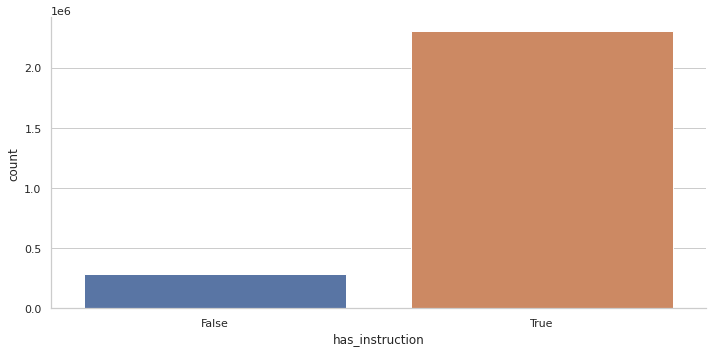

True     2302569
False     283448
Name: has_instruction, dtype: int64

In [ ]:
sns.catplot(x='has_instruction', kind='count', data=cleaned_df, height=5, aspect=2)
plt.show()
cleaned_df['has_instruction'].value_counts()

Most of them have delivery instructions

###Feature engineering using the order create date timestamp




From the dataset, there is one datetime attributes available - 'created_timestamp_local'. The attribute 'created_timestamp_local' is important since the schedule of delivery only starts after the order is created. To extract information from the attribute, the feature engineering is performed and the new attributes 'Month', 'Day', 'Day of week' and 'Weekend','Hour' are created as there might be peak period during certain month, day, hour or on weekend.

In [ ]:
cleaned_df['created_timestamp_local'] = pd.to_datetime(cleaned_df.created_timestamp_local)

In [ ]:
cleaned_df['Month'] = cleaned_df['created_timestamp_local'].apply(lambda x: x.month)
cleaned_df['Day'] = cleaned_df['created_timestamp_local'].apply(lambda x: x.day)
cleaned_df['Hour'] = cleaned_df['created_timestamp_local'].apply(lambda x: x.hour)
cleaned_df['DOW'] = cleaned_df['created_timestamp_local'].dt.dayofweek
cleaned_df['Weekend'] = cleaned_df['created_timestamp_local'].apply(lambda x: 1 if x.weekday() >=5 else 0)

In [ ]:
cleaned_df.head()

,order_id,order_value,order_items_count,created_timestamp_local,has_instruction,logistics_dropoff_distance,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction,class,Month,Day,Hour,DOW,Weekend
618,b8ds-tqhf,40,10,2021-03-11 20:19:50,True,58,False,False,False,False,False,False,False,False,small,3,11,20,3,0
619,x5xx-j2d2,35,10,2021-03-12 18:42:48,True,39,False,False,False,False,False,False,False,False,small,3,12,18,4,0
620,x6qu-14kt,42,12,2021-03-27 11:29:17,True,40,False,False,True,False,False,False,False,False,small,3,27,11,5,1
621,x3yw-rhc5,14,11,2021-03-02 22:08:52,True,44,False,False,False,False,False,False,False,False,small,3,2,22,1,0
622,y9zp-58q7,38,10,2021-03-23 20:35:26,True,71,False,False,False,False,False,False,False,False,small,3,23,20,1,0


In [ ]:
for col in columns_binary:
  cleaned_df[col] = cleaned_df[col].astype(int)
  cleaned_df[col] = cleaned_df[col].astype(int)

In [ ]:
cleaned_df.head()

,order_id,order_value,order_items_count,created_timestamp_local,has_instruction,logistics_dropoff_distance,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction,class,Month,Day,Hour,DOW,Weekend
618,b8ds-tqhf,40,10,2021-03-11 20:19:50,1,58,0,0,0,0,0,0,0,0,small,3,11,20,3,0
619,x5xx-j2d2,35,10,2021-03-12 18:42:48,1,39,0,0,0,0,0,0,0,0,small,3,12,18,4,0
620,x6qu-14kt,42,12,2021-03-27 11:29:17,1,40,0,0,1,0,0,0,0,0,small,3,27,11,5,1
621,x3yw-rhc5,14,11,2021-03-02 22:08:52,1,44,0,0,0,0,0,0,0,0,small,3,2,22,1,0
622,y9zp-58q7,38,10,2021-03-23 20:35:26,1,71,0,0,0,0,0,0,0,0,small,3,23,20,1,0


###EDA on categorical columns

3    2581372
4       4645
Name: Month, dtype: int64
------------------
6     99473
13    98602
14    97216
21    95512
20    94207
7     92457
5     91873
12    90782
28    90772
27    88589
4     85729
19    85391
11    84876
3     81674
18    81606
10    80923
9     80553
26    79413
2     79136
17    79063
16    78566
8     77555
15    77233
1     76472
31    76237
23    75539
24    75245
30    74978
25    74012
22    72196
29    70137
Name: Day, dtype: int64
------------------
18    248681
11    248056
12    243656
19    241668
17    192753
20    179180
13    175601
14    133643
10    126171
16    125819
15    115683
21    110941
9      92012
22     73976
8      65045
23     61217
0      45358
1      29358
7      27866
2      17047
6      10237
3      10110
4       6624
5       5315
Name: Hour, dtype: int64
------------------
0    1829189
1     756828
Name: Weekend, dtype: int64
------------------
2    393142
1    388772
5    380871
6    375957
0    368948
4    347459
3    330868
N

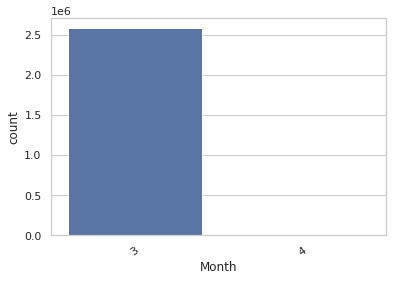

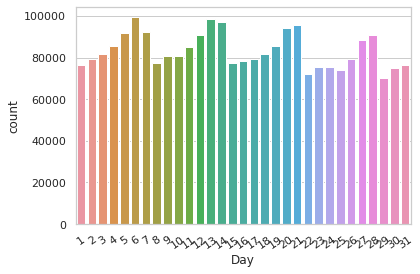

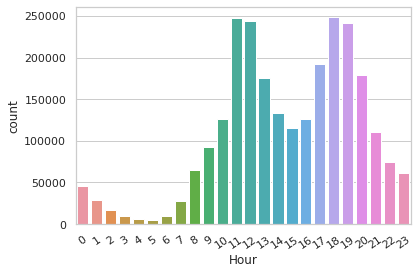

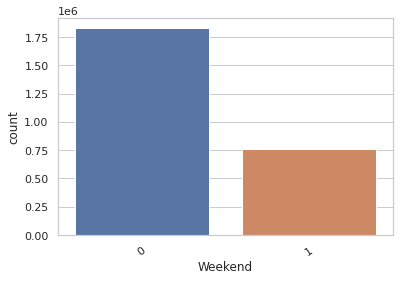

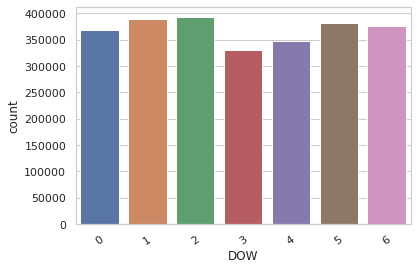

In [ ]:
categorical_columns = ['Month','Day','Hour','Weekend','DOW']
for i,c in enumerate(categorical_columns):
    df_cat = cleaned_df[c].value_counts().to_frame().reset_index()
    df_cat.columns = [c,"count"]
    plt.figure(i)
    sns.barplot(df_cat[c],df_cat["count"])
    plt.xticks(rotation=35)
    #plt.figure(figsize = (10,8))
    print(cleaned_df[c].value_counts())
    print("------------------")



*  Most of demands are from the weekend

*   There are three obvious patterns in demand by the created hour: 0am - 5am, 6am-3pm, 4pm-11pm.

*   Most of our data is from March 2021 as given in description and there are very few from April




### Final feature set

In [ ]:
cleaned_df.columns

Index(['order_id', 'order_value', 'order_items_count',
       'created_timestamp_local', 'has_instruction',
       'logistics_dropoff_distance', 'has_phone_number',
       'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction', 'class', 'Month',
       'Day', 'Hour', 'DOW', 'Weekend'],
      dtype='object')

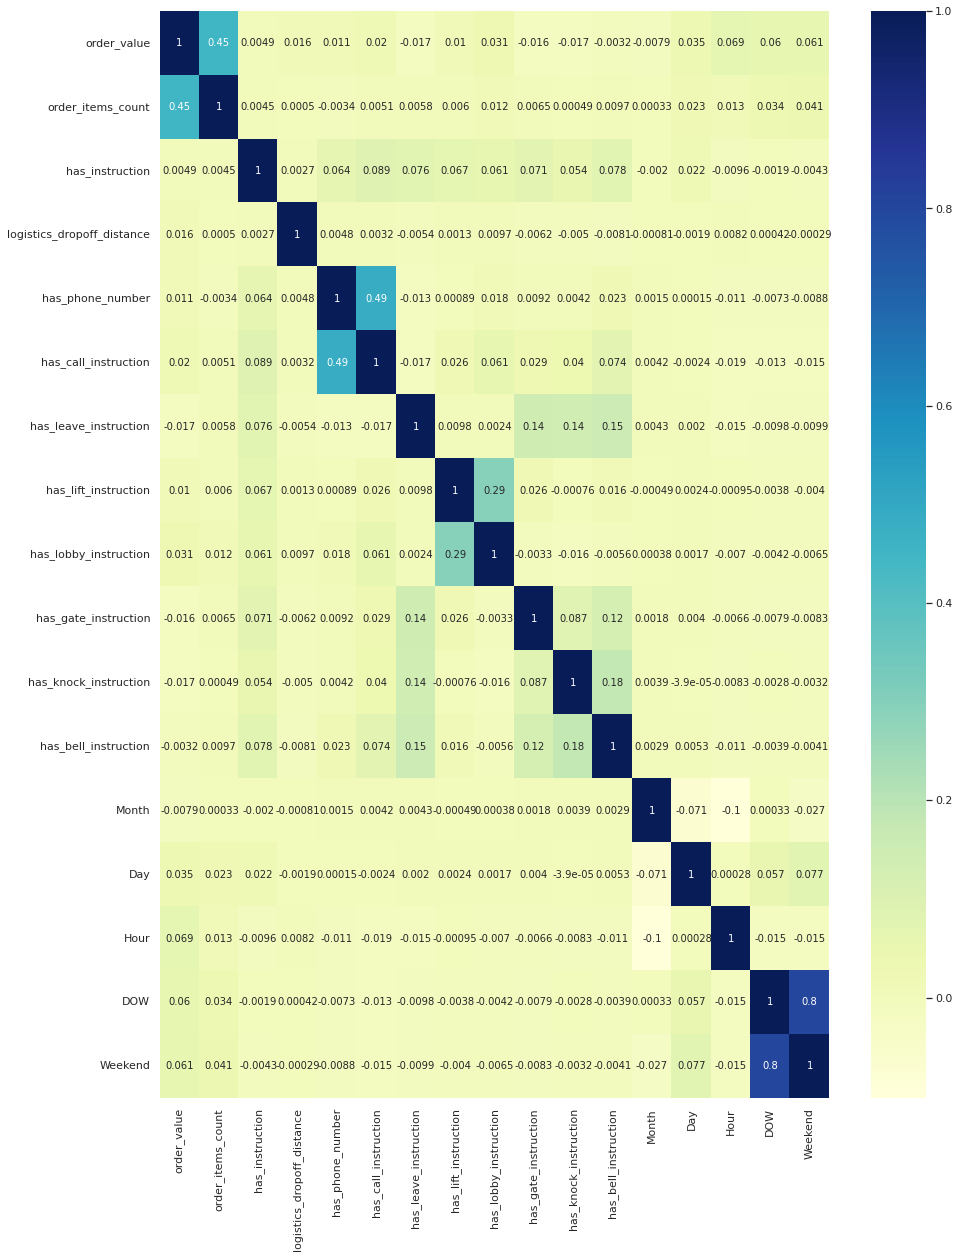

In [ ]:

# plotting correlation heatmap
plt.figure(figsize=(15,20))
corrMatrix = cleaned_df.corr()
sns.heatmap(corrMatrix, cmap="YlGnBu", annot=True)  
plt.show()

In [ ]:
thresh = 0.8
t1 = corrMatrix.abs()
t1 = t1.unstack()
T = t1.sort_values(kind="quicksort")
print('Features with correlation greater than {}'.format(thresh))
print(T[(T>thresh) & (T<1.0)].drop_duplicates())

Features with correlation greater than 0.8
DOW  Weekend   0.801
dtype: float64


There isn't much correlated variables in pur feature set apart from DOW and weekend

In [ ]:
print('Most correlated features to relevance')
print('-'*50)
corrMatrix.abs()['logistics_dropoff_distance'].sort_values(ascending=False)

Most correlated features to relevance
--------------------------------------------------


logistics_dropoff_distance   1.000
order_value                  0.016
has_lobby_instruction        0.010
Hour                         0.008
has_bell_instruction         0.008
has_gate_instruction         0.006
has_leave_instruction        0.005
has_knock_instruction        0.005
has_phone_number             0.005
has_call_instruction         0.003
has_instruction              0.003
Day                          0.002
has_lift_instruction         0.001
Month                        0.001
order_items_count            0.001
DOW                          0.000
Weekend                      0.000
Name: logistics_dropoff_distance, dtype: float64


*  We can eliminate "created_timestamp_local" feature now as we have extracted 
enough features from it 
*   Will remove "Month" as well as the variance is very low




In [ ]:

final_df = cleaned_df[['order_id', 'order_value', 'order_items_count',
        'has_instruction','has_phone_number', 'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction','has_knock_instruction', 'has_bell_instruction', 
       'Day', 'Hour', 'Weekend','logistics_dropoff_distance']].reset_index(drop=True)


In [ ]:
final_df.head()

,order_id,order_value,order_items_count,has_instruction,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction,Day,Hour,Weekend,logistics_dropoff_distance
0,b8ds-tqhf,40,10,1,0,0,0,0,0,0,0,0,11,20,0,58
1,x5xx-j2d2,35,10,1,0,0,0,0,0,0,0,0,12,18,0,39
2,x6qu-14kt,42,12,1,0,0,1,0,0,0,0,0,27,11,1,40
3,x3yw-rhc5,14,11,1,0,0,0,0,0,0,0,0,2,22,0,44
4,y9zp-58q7,38,10,1,0,0,0,0,0,0,0,0,23,20,0,71


##Modeling

Lets split the dataset as train and test 

In [ ]:
final_df.nunique()

order_id                      2586017
order_value                       412
order_items_count                  52
has_instruction                     2
has_phone_number                    2
has_call_instruction                2
has_leave_instruction               2
has_lift_instruction                2
has_lobby_instruction               2
has_gate_instruction                2
has_knock_instruction               2
has_bell_instruction                2
Day                                31
Hour                               24
Weekend                             2
logistics_dropoff_distance       1833
dtype: int64

In [ ]:
X1 = final_df.drop(['order_id', 'logistics_dropoff_distance'], axis=1)
X= X1.values #returns a numpy array
y = final_df['logistics_dropoff_distance'].values  

In [ ]:
X1.columns

Index(['order_value', 'order_items_count', 'has_instruction',
       'has_phone_number', 'has_call_instruction', 'has_leave_instruction',
       'has_lift_instruction', 'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction', 'Day', 'Hour',
       'Weekend'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=25) 

In [ ]:
#error display function
def run_error_result(actual,forecast,name):

    def mae(actual,forecast):
        result = 0 
        for a,f in zip(actual,forecast):
            result += abs(a-f)
        return result/len(forecast)

    def rmse(actual, forecast): 
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        return rmse

    
    return pd.DataFrame({'MAE':[mae(actual, forecast)],'RMSE': [rmse(actual,forecast)]},index=pd.Series([name]))

In [ ]:
def plot_feature_importance(importances,features,model_type):
  indices = np.argsort(importances)

  plt.figure(figsize=(12,16))
  plt.title('Feature Importances for {}'.format(model_type))
  plt.barh(range(len(indices)), importances[indices], color='g', align='center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.xlabel('Relative Importance')
  plt.show()
  return importances[indices]

**Model 1 : Linear regression**

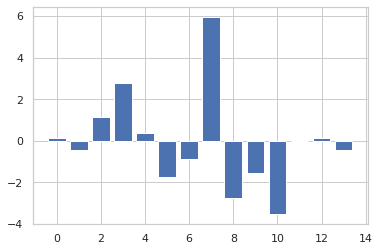

        MAE    RMSE
Test 44.718 110.384
         MAE    RMSE
Train 44.739 110.413


In [ ]:
# #fit LR model
model = LinearRegression().fit(X_train, y_train)    
# get importance
importance = model.coef_
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

pred_test = model.predict(X_test)
## predict train set  (in-sample)
pred_train = model.predict(X_train)

print(run_error_result(y_test, pred_test,'Test'))
print(run_error_result(y_train, pred_train,'Train'))



**Model 2 : Elastic net Regression**

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
enet= ElasticNet().fit(X_train, y_train)
## predict test set  (out-sample)
pred_test = enet.predict(X_test)
## predict train set  (in-sample)
pred_train = enet.predict(X_train)

print(run_error_result(y_test, pred_test,'Test'))
print(run_error_result(y_train, pred_train,'Train'))

        MAE    RMSE
Test 44.736 110.396
         MAE    RMSE
Train 44.758 110.426


**Model 3 : KNN**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knnr = KNeighborsRegressor()
knnr.fit(X_train, y_train)

## predict test set  (out-sample)
pred_test = knnr.predict(X_test)
## predict train set  (in-sample)
pred_train = knnr.predict(X_train)




In [ ]:
print(run_error_result(y_test, pred_test,'Test'))
print(run_error_result(y_train, pred_train,'Train'))

        MAE    RMSE
Test 52.836 121.034
         MAE    RMSE
Train 47.211 108.677


**Model 4 : Random Forest Regressor**


        MAE    RMSE
Test 48.293 113.892
         MAE    RMSE
Train 42.266 100.714


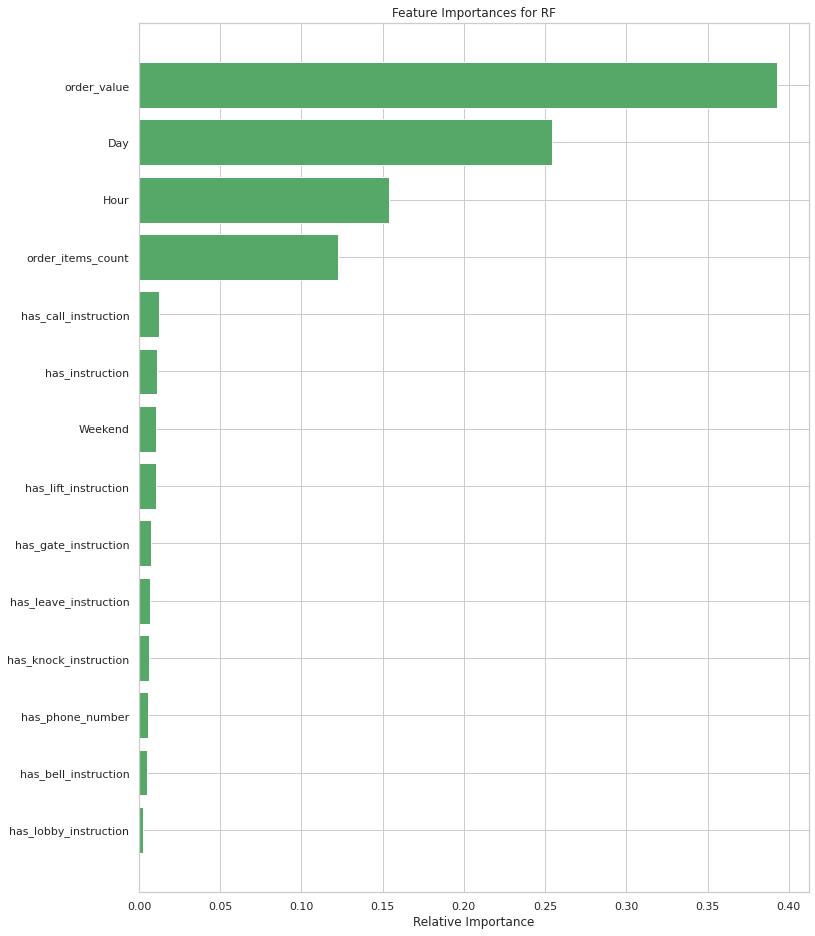

In [ ]:
# random forest fit
rf = RandomForestRegressor(n_estimators = 30,min_samples_split=8,max_features =4,n_jobs=1,)
rf.fit(X_train, y_train)

## predict test set  (out-sample)
pred_test = rf.predict(X_test)
## predict train set  (in-sample)
pred_train = rf.predict(X_train)

print(run_error_result(y_test, pred_test,'Test'))
print(run_error_result(y_train, pred_train,'Train'))
#prepare data for Tree model
feature_importance=plot_feature_importance(rf.feature_importances_,X1.columns,'RF')  



In [ ]:
# import catboost as cat
# from catboost import Pool
# #Creating pool object for train dataset. we give information of categorical fetures to parameter cat_fetaures

# #List of categorical columns
# categoricalcolumns =['Day','Hour','Weekend','DOW']
# print("Names of categorical columns : ", categoricalcolumns)
# #Get location of categorical columns
# cat_features = [X1.columns.get_loc(col) for col in categoricalcolumns]
# print("Location of categorical columns : ",cat_features)
# train_data = Pool(data=X_train,
#                   label=y_train,
#                   cat_features=cat_features
#                  )
# #Creating pool object for test dataset
# test_data = Pool(data=X_test,
#                   label=y_test,
#                   cat_features=cat_features
#                  )
# catr = cat.CatBoostRegressor(random_state=100,loss_function='RMSE')
# catr.fit(X_train, y_train,eval_set=(X_test, y_test))
# ## predict test set  (out-sample)
# pred_test = catr.predict(X_test)
# ## predict train set  (in-sample)
# pred_train = catr.predict(X_train)

# print(run_error_result(y_test, pred_test,'test'))
# print(run_error_result(y_train, pred_train,'train'))

# #prepare data for Tree model
# feature_importance=plot_feature_importance(catr.feature_importances_,X1.columns,'CAT')  

**Model 5 : XGBoost**

[07:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
        MAE    RMSE
Test 44.718 110.369
         MAE    RMSE
Train 44.728 110.370


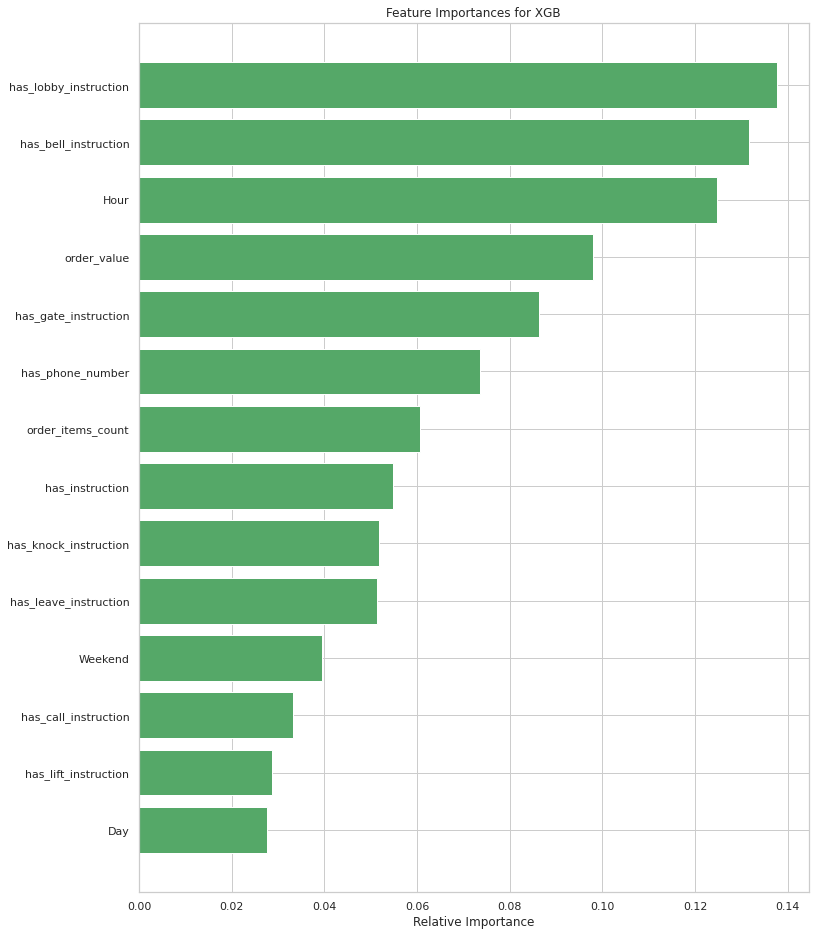

In [ ]:
# xgb fit
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

## predict test set  (out-sample)
pred_test = xgbr.predict(X_test)
## predict train set  (in-sample)
pred_train = xgbr.predict(X_train)

print(run_error_result(y_test, pred_test,'Test'))
print(run_error_result(y_train, pred_train,'Train'))
#prepare data for Tree model
feature_importance=plot_feature_importance(xgbr.feature_importances_,X1.columns,'XGB')  


**Model 6 : LightGBM**

        MAE    RMSE
Test 44.736 110.381
         MAE    RMSE
Train 44.711 110.261


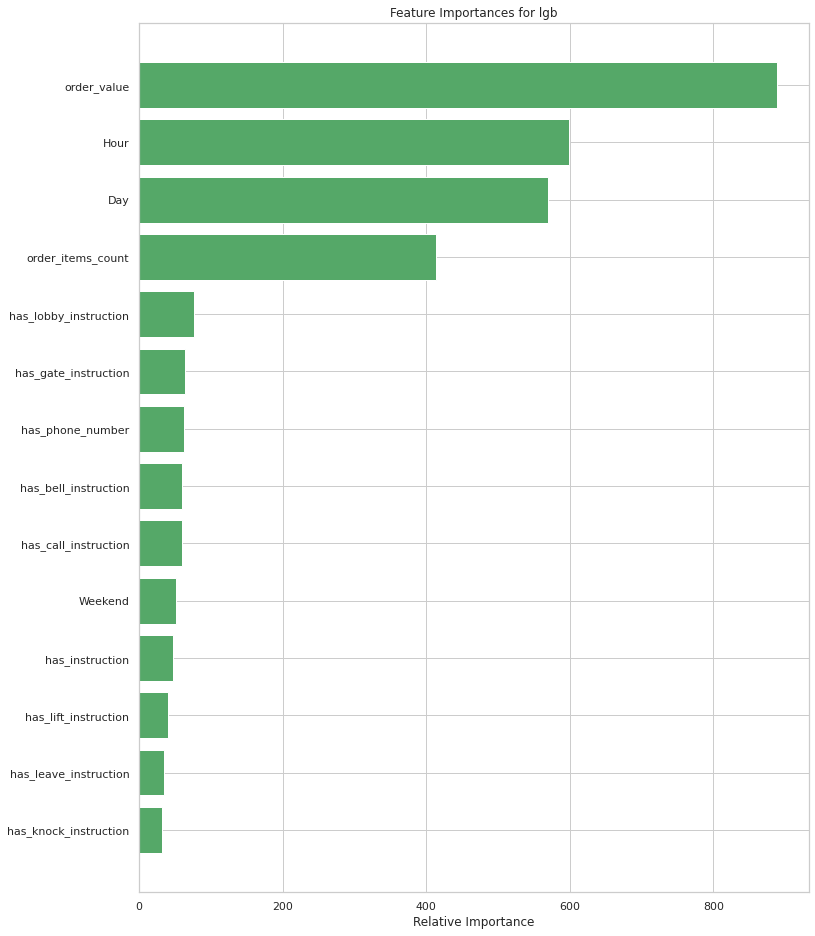

In [ ]:
from lightgbm import LGBMRegressor
lgbr = LGBMRegressor()
lgbr.fit(X_train, y_train)

## predict test set  (out-sample)
pred_test = lgbr.predict(X_test)
## predict train set  (in-sample)
pred_train = lgbr.predict(X_train)

print(run_error_result(y_test, pred_test,'Test'))
print(run_error_result(y_train, pred_train,'Train'))
#prepare data for Tree model
feature_importance=plot_feature_importance(lgbr.feature_importances_,X1.columns,'lgb')  

- XGBoost model has best performance among all the tried out models. 
- Elasticnet regression and LightGBM also performed well, and has MAE and RMSE scores that are close to that of XGBoost
-So we finalise XGBoost , and we can further improve performance by tuning hyperparameters
-As per our best model *has_lobby_instruction, has_bell_instruction, Hour, Order_value, has_gate_instruction* are most important features

##	Ideas about improvements 


- Hyerparameter tuning
- K-fold Cross validation to get clear picture of model performance

- Adding more domain specific features like :
 

    1.Experience of delivery person, rating
    2.Location type(for e.g urban/ rural , in rural areas sometimes GPS signal will be weak )
    3.Payment mode(sometimes if it's cash on delivery , it will take longer time to collect the money)
    4.From the address we can collect information like in which floor the apartment is (higher floors might cause longer delivery)
    5.Whether the rider speaks both local language and english 


-   Can check if there are any locations that cause longer dropoff distance repeatedly

- Try out deep learning models
